In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


import torch

In [1]:
import json
import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from transformers import AutoTokenizer, AutoModel

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

D:\Anaconda\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\weipa\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [32]:
alz_cancer_papers = json.load(open('alz&cancer.json'))
print(len(alz_cancer_papers))

1998


In [33]:
papers = alz_cancer_papers.copy()
# we can use a persistent dictionary (via shelve) so we can stop and restart if needed
# alternatively, do the same but with embeddings starting as an empty dictionary
embeddings = {}
for pmid, paper in tqdm.tqdm(papers.items()):
    data = [paper["ArticleTitle"] + tokenizer.sep_token + paper["ArticleAbstract"]]
    inputs = tokenizer(
        data, padding=True, truncation=True, return_tensors="pt", max_length=512
    )
    result = model(**inputs)
    # take the first token in the batch as the embedding
    embeddings[pmid] = result.last_hidden_state[:, 0, :].detach().numpy()[0]

# turn our dictionary into a list
embeddings = [embeddings[pmid] for pmid in papers.keys()]

100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [12:04<00:00,  2.76it/s]


In [34]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
embeddings_pca = pd.DataFrame(
    pca.fit_transform(embeddings),
    columns=['PC0', 'PC1', 'PC2']
)
embeddings_pca["query"] = [paper["query"] for paper in papers.values()]

In [36]:
embeddings_pca

,PC0,PC1,PC2,query
0,-1.040141,-5.184434,-0.222884,Alzheimer
1,-5.402351,4.374268,0.928445,Alzheimer
2,-5.520820,4.610436,-1.998771,Alzheimer
3,-5.684639,-4.256922,-0.069922,Alzheimer
4,-5.909279,-2.143645,0.723237,Alzheimer
...,...,...,...,...
1993,1.974529,-4.315622,5.541237,Cancer
1994,5.472513,6.085035,3.709071,Cancer
1995,3.539508,-4.110456,2.859843,Cancer
1996,2.834004,-2.746227,4.597492,Cancer


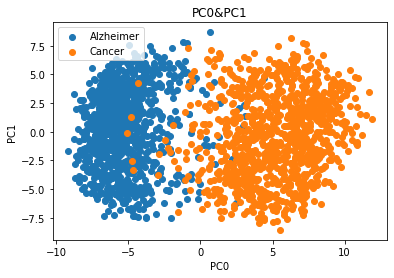

In [54]:
alz_PC0 = embeddings_pca[embeddings_pca['query']=='Alzheimer']['PC0']
alz_PC1 = embeddings_pca[embeddings_pca['query']=='Alzheimer']['PC1']
alz_PC2 = embeddings_pca[embeddings_pca['query']=='Alzheimer']['PC2']
cancer_PC0 = embeddings_pca[embeddings_pca['query']=='Cancer']['PC0']
cancer_PC1 = embeddings_pca[embeddings_pca['query']=='Cancer']['PC1']
cancer_PC2 = embeddings_pca[embeddings_pca['query']=='Cancer']['PC2']

plt.scatter(alz_PC0, alz_PC1, label="Alzheimer")
plt.scatter(cancer_PC0, cancer_PC1, label="Cancer")
plt.title("PC0&PC1")
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.legend()
plt.show()

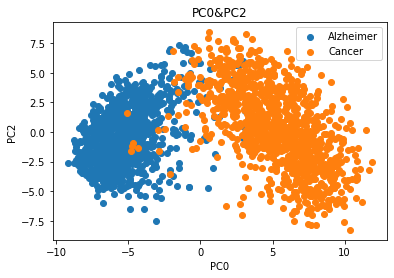

In [55]:
plt.scatter(alz_PC0, alz_PC2, label="Alzheimer")
plt.scatter(cancer_PC0, cancer_PC2, label="Cancer")
plt.title("PC0&PC2")
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.legend()
plt.show()

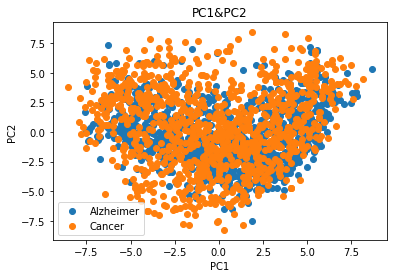

In [56]:
plt.scatter(alz_PC1, alz_PC2, label="Alzheimer")
plt.scatter(cancer_PC1, cancer_PC2, label="Cancer")
plt.title("PC1&PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()